In [1]:
#data and visualization
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

#splits, scalers, and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
import numpy as np
import pandas as pd

%matplotlib inline
#%config InlineBackend.figure_format = 'svg' 

# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#load in data
model_data = pickle.load(open('model_data','rb'))

# Initial Looks

/Applications/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Applications/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


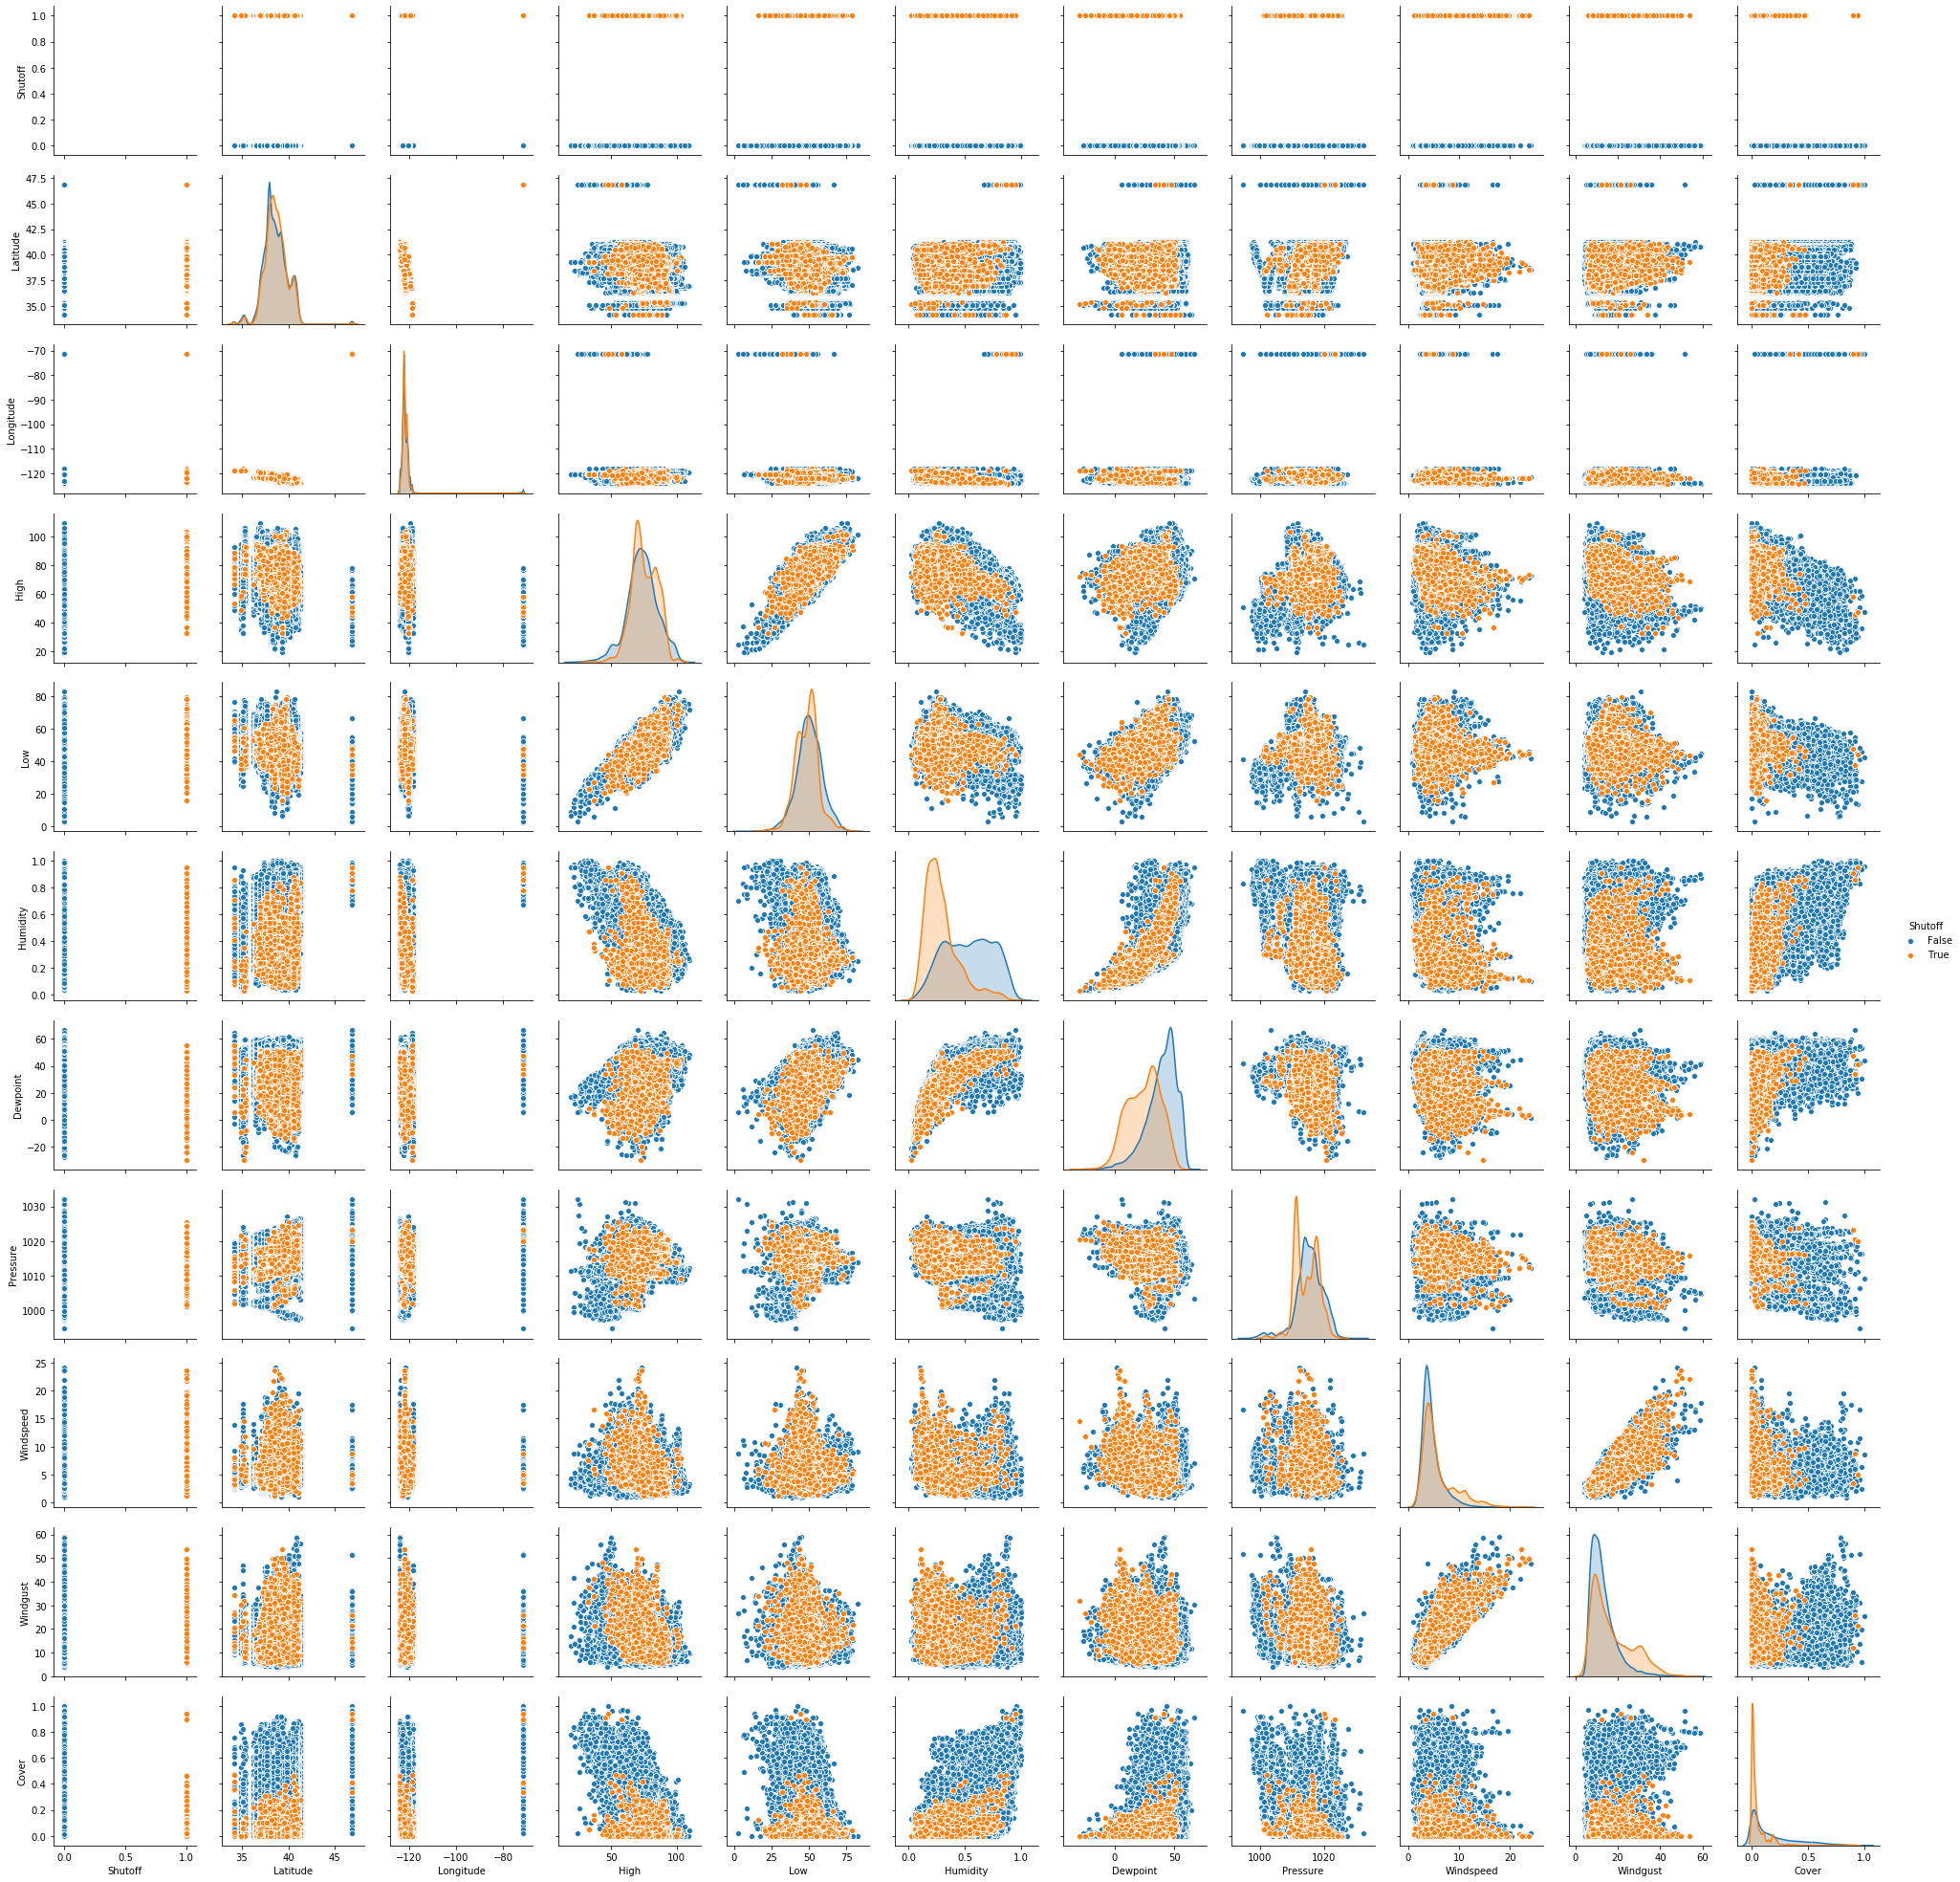

In [3]:
sns.pairplot(model_data, hue='Shutoff')

In [23]:
scouting_df = model_data.copy()
# scouting_df['Shutoff'] = scouting_df['Shutoff'].astype(int)

# scouting_df['Power'] = scouting_df['Shutoff'].apply(lambda x: (x and 'Yes') or 'No')
scouting_df = scouting_df[['High', 'Humidity', 'Dewpoint', 'Pressure', 'Windgust', 'Cover', 'Shutoff']] 

In [71]:
lr_model = LogisticRegression(solver="liblinear")
nb_model = GaussianNB()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier(n_estimators=100) #max depth 3

models = ["lr_model", "nb_model", "knn_model", "rf_model"]

In [72]:
#train test split
#Shutoff column set as target
X_train, X_test, y_train, y_test = train_test_split(scouting_df.loc[:, scouting_df.columns != 'Shutoff'], scouting_df.loc[:, 'Shutoff'], 
                                                    test_size = 0.2, random_state=22)

In [73]:
model_design = [eval(n) for n in models]
model_list = list(zip(models, model_design))

In [74]:
for model, design in model_list:
    design.fit(X_train, y_train)

In [75]:
for model, design in model_list:
    print(f'{model} score: {design.score(X_train, y_train)}')

lr_model score: 0.8722005842259006
nb_model score: 0.8225008114248621
knn_model score: 0.9521259331385914
rf_model score: 0.9995942875689711


In [76]:
for model, design in model_list:
    print(model, 'roc score: ', roc_auc_score(y_train, design.predict_proba(X_train)[:,1]))

lr_model roc score:  0.8413860784530152
nb_model roc score:  0.8474855938767606
knn_model roc score:  0.9876927328860127
rf_model roc score:  0.999991409205877


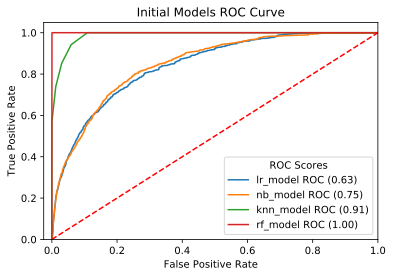

In [78]:
plt.figure()

for model, design in model_list:
    fpr, tpr, thresholds = roc_curve(y_train, design.predict_proba(X_train)[:,1])
    #plt.plot([0,1],[0,1],ls='--')

    auc = roc_auc_score(y_train,design.predict(X_train))
    plt.plot(fpr, tpr, label='%s ROC (%0.2f)' % (model, auc))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Initial Models ROC Curve');
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.025, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right", title = 'ROC Scores')
#plt.show()   # Display
plt.savefig('initial models ROC', transparent = True)


# Class Imbalance

In [31]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, ADASYN

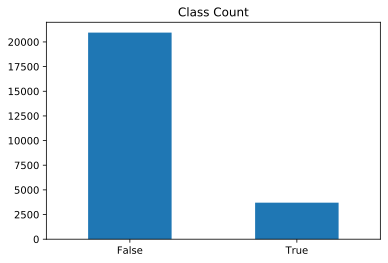

In [32]:
target_count = y_train.value_counts()
target_count.plot(kind='bar', title='Class Count', rot=0);
#plt.savefig('class imbalance', transparent = True)

## Cross Validation and Model Selection

In [79]:
#cross validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 22)
CV_precision = defaultdict(list) 
CV_recall = defaultdict(list)  
CV_accuracy = defaultdict(list)
CV_f1 = defaultdict(list)
CV_roc = defaultdict(list)
X_train_cv_data = np.array(X_train)
y_train_cv_data = np.array(y_train)
models = {
    'Logistic Regression': LogisticRegression(solver="lbfgs", max_iter = 3000),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=3000, max_depth=3),
    'XG Boost': XGBClassifier(n_estimators=3000, max_depth=3, learning_rate=0.1),
    'AdaBoost': AdaBoostClassifier(n_estimators=3000, learning_rate=0.1),
}

for model_name, model in models.items():
    for train_idx, val_idx in kf.split(X_train_cv_data, y_train_cv_data):
        X_tr, y_tr = X_train_cv_data[train_idx], y_train_cv_data[train_idx] # stratified kfold
        X_adasyn_train, y_adasyn_train = ADASYN(sampling_strategy = 0.67, random_state = 22).fit_sample(X_tr, y_tr)
        X_val, y_val = X_train_cv_data[val_idx], y_train_cv_data[val_idx]
        model.fit(X_adasyn_train, y_adasyn_train)
        y_pred = model.predict(X_val)
        precision = precision_score(y_val, y_pred)
        CV_precision[model_name].append(precision)
        recall = recall_score(y_val, y_pred)
        CV_recall[model_name].append(recall)
        accuracy = accuracy_score(y_val, y_pred)
        CV_accuracy[model_name].append(accuracy)
        f1 = f1_score(y_val, y_pred)
        CV_f1[model_name].append(f1)
        roc = roc_auc_score(y_val, y_pred)
        CV_roc[model_name].append(roc)


In [80]:
#oversampling 2:3
for model in CV_precision:
    print(model, 'precision', np.mean(CV_precision[model]))
    print(model, 'recall', np.mean(CV_recall[model]))
    print(model, 'accuracy', np.mean(CV_accuracy[model]))
    print(model, 'f1', np.mean(CV_f1[model]))
    print(model, 'roc', np.mean(CV_roc[model]))
    print('\n')
    

Logistic Regression precision 0.4032741004013426
Logistic Regression recall 0.6597499805084821
Logistic Regression accuracy 0.8022964884318787
Logistic Regression f1 0.5003266891705949
Logistic Regression roc 0.7436359477206439


KNN precision 0.6100184572997173
KNN recall 0.9318616661230349
KNN accuracy 0.9003569798645842
KNN f1 0.7372800757924216
KNN roc 0.9133248200497794


DecisionTree precision 0.47431803331174394
DecisionTree recall 0.8160450504395815
DecisionTree accuracy 0.8339845687052287
DecisionTree f1 0.5977392082945403
DecisionTree roc 0.8265970106904416


Random Forest precision 0.4307858808917347
Random Forest recall 0.752626968626681
Random Forest accuracy 0.8130483700185639
Random Forest f1 0.5474927393706899
Random Forest roc 0.7881991539245338


XG Boost precision 0.8010695635746666
XG Boost recall 0.8712665905661565
XG Boost accuracy 0.9481906191653735
XG Boost f1 0.8345660274025974
XG Boost roc 0.9165442528942481


AdaBoost precision 0.5438006948293888
AdaBoost rec

## Visualizations

In [35]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

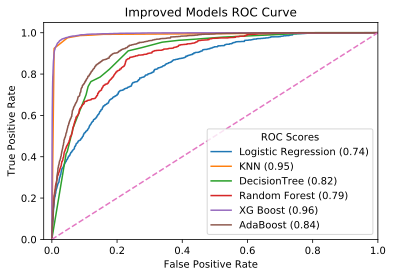

In [86]:
plt.figure()
for m in models.items():

    fpr, tpr, thresholds = roc_curve(y_train, m[1].predict_proba(np.array(X_train))[:,1])
    auc = roc_auc_score(y_train, m[1].predict(np.array(X_train)))
    plt.plot(fpr, tpr, label='%s (%0.2f)' % (m[0], auc))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Improved Models ROC Curve');
plt.plot([0,1],[0,1],ls='--')
plt.xlim([-0.025, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right", title = 'ROC Scores')
#plt.show()   # Display
plt.savefig('adjusted models ROC', transparent = True)

In [88]:
final_model = models['XG Boost']

In [89]:
final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=3000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [90]:
y_predict = final_model.predict(X_train)

<Figure size 900x600 with 0 Axes>

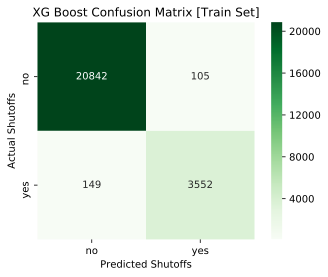

In [46]:
model_confusion = confusion_matrix(y_train, y_predict)
plt.figure(dpi=150)
plt.figure(dpi=150)
sns.heatmap(model_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
            xticklabels=['no', 'yes'],
            yticklabels=['no', 'yes'])

plt.xlabel('Predicted Shutoffs')
plt.ylabel('Actual Shutoffs')
plt.title('XG Boost Confusion Matrix [Train Set]')
plt.savefig('training confusion matrix', transparent = True)

In [47]:
y_pred = final_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

print([precision, recall, accuracy, f1, roc])

[0.8678839957035446, 0.8577494692144374, 0.9582995294499432, 0.8627869727709556, 0.9170953819927771]


In [92]:

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.9713,   Recall: 0.9597


In [48]:

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_pred), 
                                                     recall_score(y_test, y_pred)))

Default threshold:
Precision: 0.8679,   Recall: 0.8577


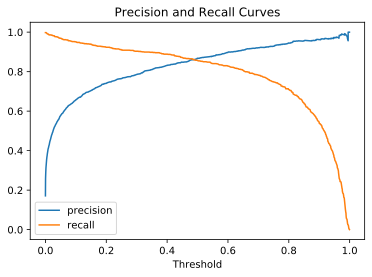

In [50]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, final_model.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');
plt.savefig('precision recall threshold', transparent = True)

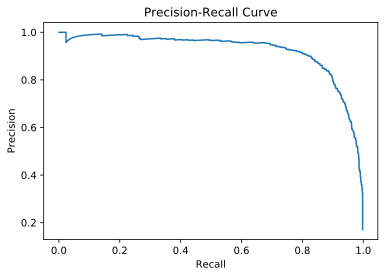

In [52]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");
plt.savefig('precision recall curve', transparent = True)

In [53]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
#from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:,1])

In [54]:
final_model.predict_proba(X_test)[9,:]

array([9.9992996e-01, 7.0032867e-05], dtype=float32)

ROC AUC score =  0.9819684387442352


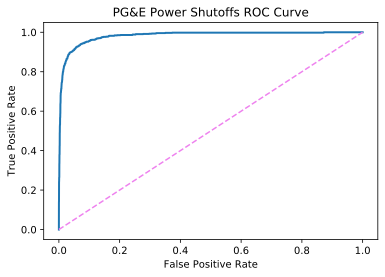

In [56]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PG&E Power Shutoffs ROC Curve');
print("ROC AUC score = ", roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1]))
plt.savefig('final ROC curve', transparent = True)

    CONFUSION MATRIX

<Figure size 900x600 with 0 Axes>

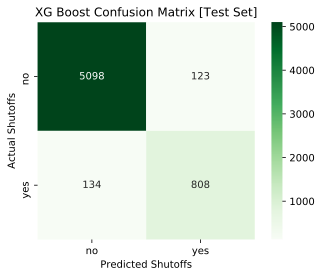

In [58]:
model_confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
plt.figure(dpi=150)
sns.heatmap(model_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
            xticklabels=['no', 'yes'],
            yticklabels=['no', 'yes'])

plt.xlabel('Predicted Shutoffs')
plt.ylabel('Actual Shutoffs')
plt.title('XG Boost Confusion Matrix [Test Set]')
plt.savefig("test confusion matrix", transparent = True)

In [59]:
print('precision: ', precision_score(y_test, y_pred), '\n'
'recall: ', recall_score(y_test, y_pred), '\n'
'accuracy: ', accuracy_score(y_test, y_pred), '\n'
'f1: ', f1_score(y_test, y_pred), '\n'
'roc: ', roc_auc_score(y_test, y_pred))

precision:  0.8678839957035446 
recall:  0.8577494692144374 
accuracy:  0.9582995294499432 
f1:  0.8627869727709556 
roc:  0.9170953819927771


    FEATURE IMPORTANCE

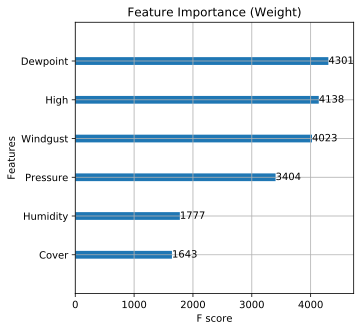

In [61]:
feature_names=['High', 'Humidity', 'Dewpoint', 'Pressure', 'Windgust', 'Cover']
final_model.get_booster().feature_names = feature_names
fig, ax = plt.subplots(1,1,figsize=(5,5))
xgb.plot_importance(final_model, ax=ax)
#plot_importance(final_model)
plt.title('Feature Importance (Weight)')
plt.show()

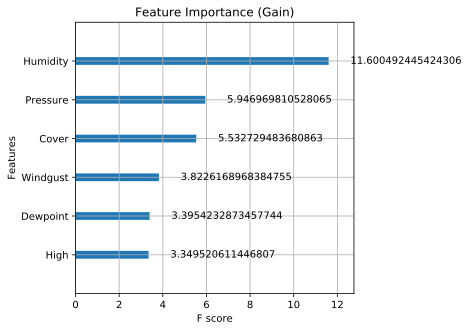

In [62]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xgb.plot_importance(final_model, ax=ax, importance_type = 'gain')
#plot_importance(final_model)
plt.title('Feature Importance (Gain)')
plt.show()

# Appendix Visualization

In [63]:
import shap
shap_values = shap.TreeExplainer(final_model).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap_values

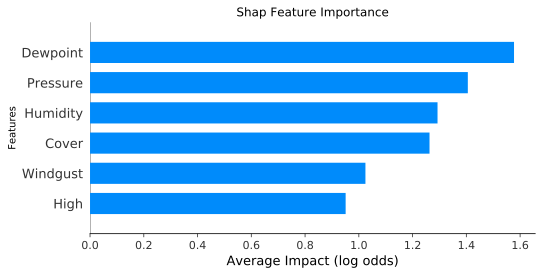

In [64]:
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
#f = plt.gcf()
plt.title('Shap Feature Importance')
plt.xlabel('Average Impact (log odds)')
plt.ylabel('Features')
plt.savefig('shap feature importance', transparent = True, format = 'svg')

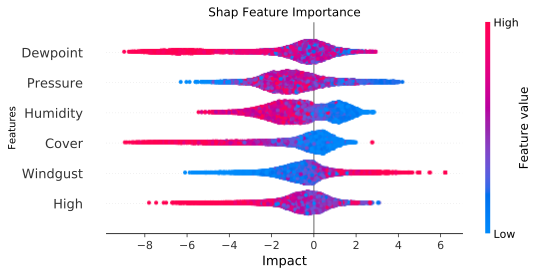

In [66]:
shap.summary_plot(shap_values, X_train, show=False)
plt.title('Shap Feature Importance')
plt.xlabel('Impact')
plt.ylabel('Features')
plt.savefig('shap feature impact', transparent = True, bbox_inches = 'tight')